In [1]:
from utils import load_dataset, train_model, validity_domains,explanation_VD
from itertools import combinations
import numpy as np
from tqdm import tqdm

In [2]:
dataset = "flame"
model_name = "m0"
X_train, X_test, y_train, y_test, X, y, feature_names = load_dataset(dataset)
model = train_model(X_train,y_train, model_name)
print(model.score(X, y))
print(model.score(X_test, y_test))

1.0
1.0


In [3]:
VD, models_VD, explainer = validity_domains(X_train,feature_names,model,threshold_diff=0.2,gamma=18)

100%|██████████| 192/192 [00:00<00:00, 2467.62it/s]


In [4]:
def best_model_coverage(VD, K=2):
    max = 0
    comb = list(combinations(np.arange(len(VD)),K))
    for c in tqdm(comb):
        a = set()
        for e in c:
            a = a.union(np.where(VD[e])[0].tolist())
        if len(a)>max:
            best_c = c
            max = len(a)
    return best_c, max

def best_model_coverage_precision(VD, K, precs, min_prec = 0.9):
    max = 0
    best_c = 0
    idx_sup = np.where(np.asarray(precs)>=min_prec)[0].tolist()
    print("keeping",len(idx_sup),"/",len(VD))
    comb = list(combinations(idx_sup,K))
    for c in tqdm(comb):
        a = set()
        for e in c:
            a = a.union(np.where(VD[e])[0].tolist())
        if len(a)>max:
            best_c = c
            max = len(a)
        if max==len(VD):
            break
    return best_c, max


In [5]:
idx, nb_pts = best_model_coverage(VD, K=3)

100%|██████████| 1161280/1161280 [00:10<00:00, 109301.33it/s]


In [6]:
print(idx)
print(nb_pts)

(24, 28, 88)
180


No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


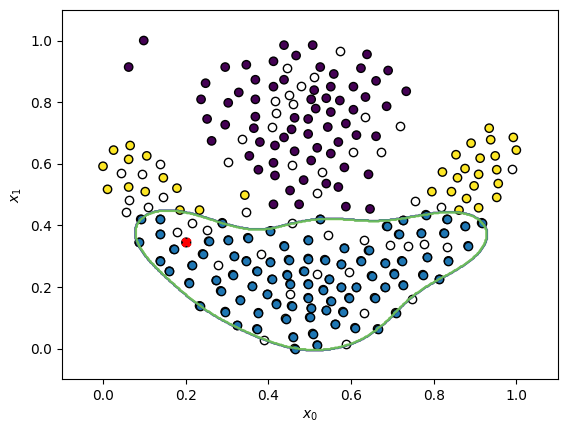

Explanation
.values =
array([0.04, 0.38])

.base_values =
0.58

.data =
array([0.20072993, 0.34456929])


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


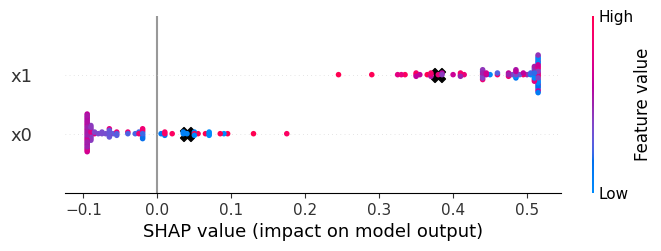

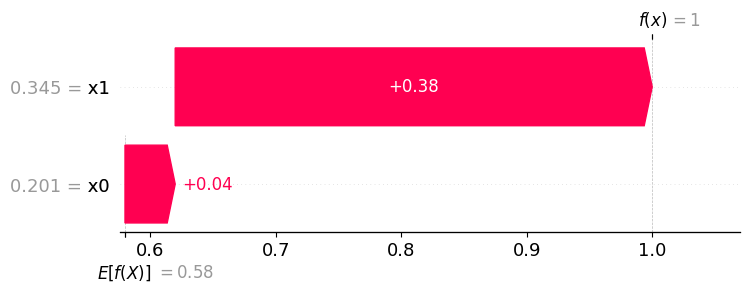

Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.


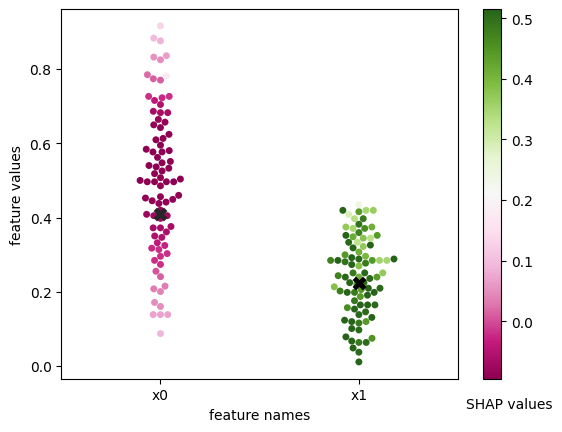

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


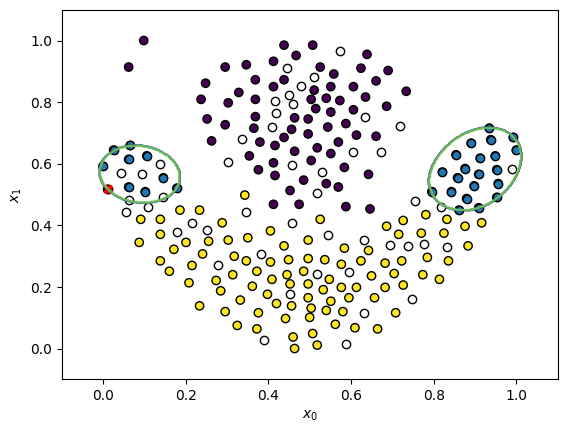

Explanation
.values =
array([ 0.43, -0.01])

.base_values =
0.58

.data =
array([0.01094891, 0.51685393])


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


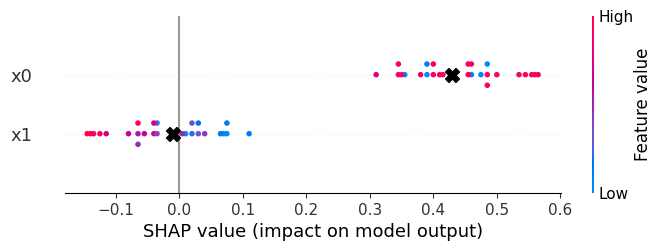

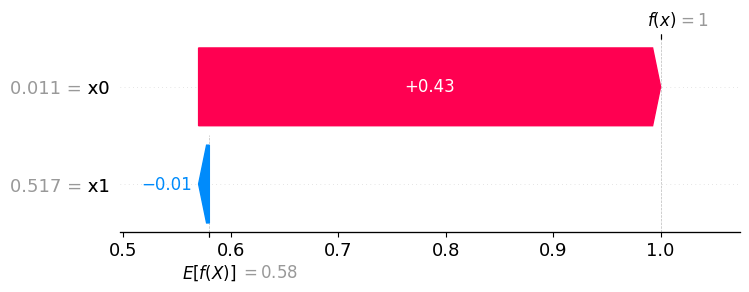

Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.


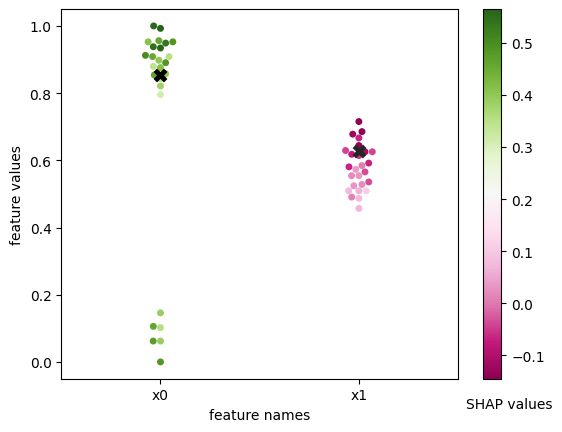

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


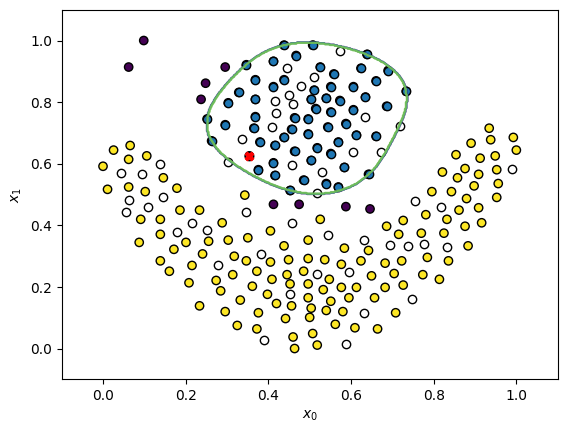

Explanation
.values =
array([-0.175, -0.405])

.base_values =
0.58

.data =
array([0.3540146 , 0.62546816])


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


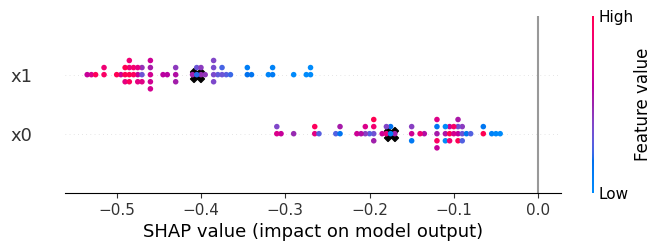

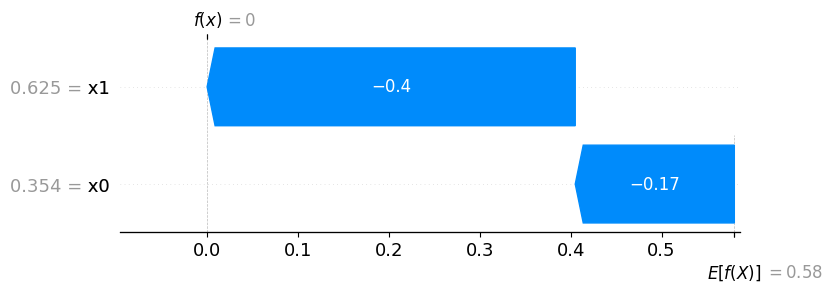

Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.


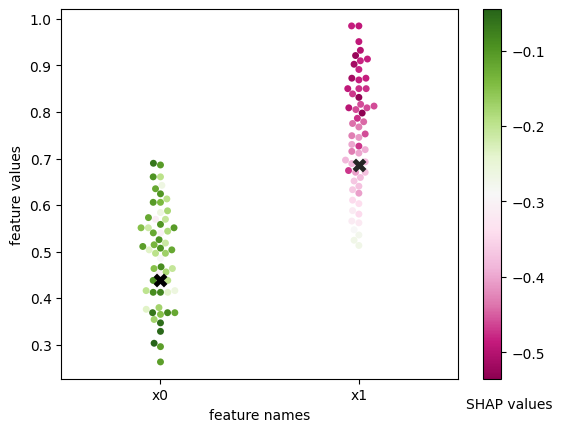

In [7]:
for i in idx:
    explanation_VD(i, X_test, X_train, VD, model, models_VD,explainer,feature_names)

VD

In [157]:
y_pred = model.predict(np.asarray(X_train))
As = [np.where(m.predict(X)==1) for m in models_VD]
precs = [np.sum(y_pred[e] == model.predict(X[As[e]]))/len(As[e][0]) for e in range(len(VD))]

In [158]:
idx, nb_pts = best_model_coverage_precision(VD, 3, precs, min_prec = 1)

  2%|▏         | 20955/1021384 [00:00<00:09, 104549.70it/s]

keeping 184 / 192


100%|██████████| 1021384/1021384 [00:09<00:00, 102266.50it/s]


In [159]:
print(idx)
print(nb_pts)

(24, 28, 88)
180


In [57]:
print(idx)
print(nb_pts)

(24, 28, 88)
180


In [161]:
l_nb_pts=[]
Ks=np.arange(1,5)
for k in Ks:
    print(k)
    idx, nb_pts = best_model_coverage_precision(VD, k, precs, 1)
    l_nb_pts.append(nb_pts/len(X_train))

100%|██████████| 16836/16836 [00:00<00:00, 143058.03it/s]

1
keeping 184 / 192
2
keeping 184 / 192
3
keeping 184 / 192



  0%|          | 16389/46217626 [00:00<09:23, 81964.38it/s]

4
keeping 184 / 192


100%|██████████| 46217626/46217626 [09:41<00:00, 79497.84it/s]


In [103]:
k=5
idx, nb_pts = best_model_coverage_precision(VD, k, precs, 1)
l_nb_pts.append(nb_pts/len(X_train))

keeping 175 / 192


MemoryError: 

In [94]:
l_nb_pts

[0.4635416666666667, 0.7760416666666666, 0.9375, 0.984375]

Text(0, 0.5, 'Training set coverage')

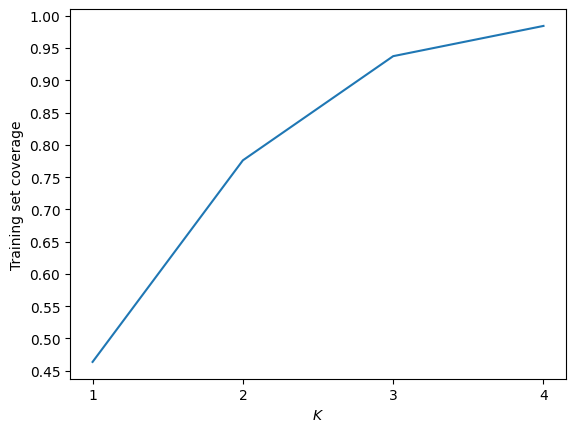

In [100]:
import matplotlib.pyplot as plt
Ks=np.arange(1,len(l_nb_pts)+1)

plt.plot(Ks,l_nb_pts)
plt.xticks(Ks)
plt.yticks(np.arange(0.45,1.04,0.05))
plt.xlabel('$K$')
plt.ylabel('Training set coverage')

Anchors

In [106]:
from anchor import anchor_tabular
import pandas as pd
from utils import isinanchorarray

explainer = anchor_tabular.AnchorTabularExplainer(
    np.unique(y),
    feature_names,
    X_train,
    {})

In [129]:
# exps = [explainer.explain_instance(x, model.predict) for x in tqdm(X_train)]
exps = [explainer.explain_instance(x, model.predict, threshold=1, delta=0.1, tau=0.15, batch_size=10) for x in tqdm(X_train)]

100%|██████████| 192/192 [00:09<00:00, 19.74it/s]


In [138]:
df = pd.DataFrame(X_train, columns=feature_names)
regions = [isinanchorarray(df,exp) for exp in exps]

In [139]:
precisions = [exp.precision() for exp in exps]

In [147]:
def best_cov_anchors(regions, K):
    max = 0
    comb = list(combinations(np.arange(len(regions)),K))
    for c in tqdm(comb):
        a = set()
        for e in c:
            a = a.union(np.where(regions[e])[0].tolist())
        if len(a)>max:
            best_c = c
            max = len(a)
    return best_c, max

def best_cov_anchors_precision(regions, K, precs, min_prec = 1):
    max = 0
    best_c = 0
    idx_sup = np.where(np.asarray(precs)>=min_prec)[0].tolist()
    print("keeping",len(idx_sup),"/",len(regions))
    comb = list(combinations(idx_sup,K))
    for c in tqdm(comb):
        a = set()
        for e in c:
            a = a.union(np.where(regions[e])[0].tolist())
        if len(a)>max:
            best_c = c
            max = len(a)
        if max==len(regions):
            break
    return best_c, max

In [119]:
best_cov_anchors(regions, 2)

100%|██████████| 18336/18336 [00:00<00:00, 72382.15it/s]


((8, 154), 168)

In [120]:
best_cov_anchors(regions, 3)

100%|██████████| 1161280/1161280 [00:21<00:00, 53336.05it/s]


((8, 43, 154), 192)

In [149]:
l_nb_pts_anchors = []
for k in range(1,5):
    print(k)
    idx, nb_pts = best_cov_anchors_precision(regions, k, precisions, min_prec = 1)
    l_nb_pts_anchors.append(nb_pts/len(X_train))

 56%|█████▌    | 4513/8128 [00:00<00:00, 44802.65it/s]

1
keeping 128 / 192
2
keeping 128 / 192


  1%|          | 2847/341376 [00:00<00:11, 28262.96it/s]

3
keeping 128 / 192


  0%|          | 5763/10668000 [00:00<06:32, 27159.20it/s]

4
keeping 128 / 192


100%|██████████| 10668000/10668000 [06:24<00:00, 27753.51it/s]


In [164]:
l_nb_pts_anchors

[0.5052083333333334,
 0.7395833333333334,
 0.8333333333333334,
 0.8333333333333334]

In [166]:
l_nb_pts

[0.4635416666666667, 0.7760416666666666, 0.9375, 0.984375]

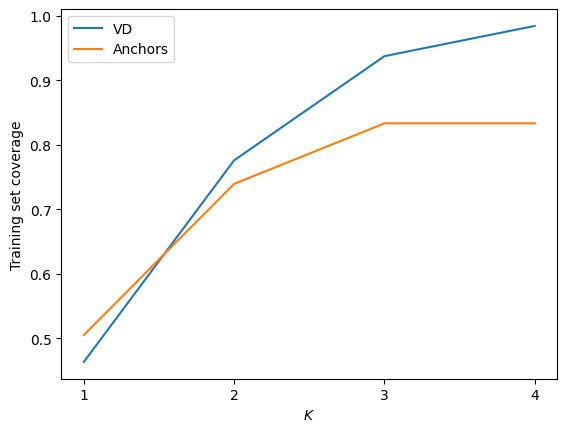

In [169]:
plt.plot(Ks,l_nb_pts,label="VD")
plt.plot(Ks,l_nb_pts_anchors,label="Anchors")
plt.xticks(Ks)
plt.legend()
plt.xlabel('$K$')
plt.ylabel('Training set coverage')
plt.savefig("figures/k_coverage.pdf")